In [16]:
import pandas as pd
import re
from textblob import TextBlob

# Function to clean the comments
def clean_comment(comment):
    # Remove HTML tags
    comment = re.sub(r'<.*?>', '', comment)
    # Remove special characters, emojis, and excessive whitespace
    comment = re.sub(r'[^A-Za-z0-9\s]', '', comment)
    comment = re.sub(r'\s+', ' ', comment).strip()
    return comment

# Function to determine the sentiment of a comment
def analyze_sentiment(comment):
    analysis = TextBlob(comment)
    # Classify as positive, negative, or neutral
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Load the CSV file
file_path = '/content/drive/MyDrive/Colab Notebooks/youtube_comments.csv'
df = pd.read_csv(file_path)

# Clean the comments
df['Cleaned_Comment'] = df['comment'].apply(clean_comment)

# Analyze sentiment
df['Sentiment'] = df['Cleaned_Comment'].apply(analyze_sentiment)

# Select the required columns
processed_df = df[['comment', 'Cleaned_Comment', 'Sentiment']]

# Save the processed data to a new CSV file
processed_df.to_csv('/content/drive/MyDrive/Colab Notebooks/processed_comments.csv', index=False)


In [17]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/processed_comments.csv")
df.head()

,comment,Cleaned_Comment,Sentiment
0,помогите песню наити !!!спс,NaN,neutral
1,"wow, swearwords. edgy and cool",wow swearwords edgy and cool,positive
2,Guys did you notice Casandra Nova at the porta...,Guys did you notice Casandra Nova at the porta...,neutral
3,Disney better not mess this up,Disney better not mess this up,positive
4,LFG,LFG,neutral


In [18]:
df.shape

(13767, 3)

# Removing null values and balancing the dataset

In [19]:
df.isna().sum()

comment              0
Cleaned_Comment    462
Sentiment           25
dtype: int64

In [20]:
df = df.dropna()

In [21]:
df.Sentiment.value_counts()

Sentiment
neutral     7103
positive    4508
negative    1694
Name: count, dtype: int64

In [22]:
# handle class imbalance

min_samples = 1600

df_positive = df[df.Sentiment=='positive'].sample(min_samples, random_state=2024)
df_negative = df[df.Sentiment=='negative'].sample(min_samples, random_state=2024)
df_neutral = df[df.Sentiment=='neutral'].sample(min_samples, random_state=2024)

In [23]:
df = pd.concat([df_positive, df_negative, df_neutral])
df.Sentiment.value_counts()

Sentiment
positive    1600
negative    1600
neutral     1600
Name: count, dtype: int64

In [24]:
df.head()

,comment,Cleaned_Comment,Sentiment
3218,Who Is Happy For The First R-Rated MCU film,Who Is Happy For The First RRated MCU film,positive
6914,THIS LOOKS AMAZING ❤❤❤❤,THIS LOOKS AMAZING,positive
9770,wow,wow,positive
10141,"Man sad, man watch logan and deadpool, man hap...",Man sad man watch logan and deadpool man happy,positive
11418,This is an example of a Trilogy where each mov...,This is an example of a Trilogy where each mov...,positive


# Visualisation

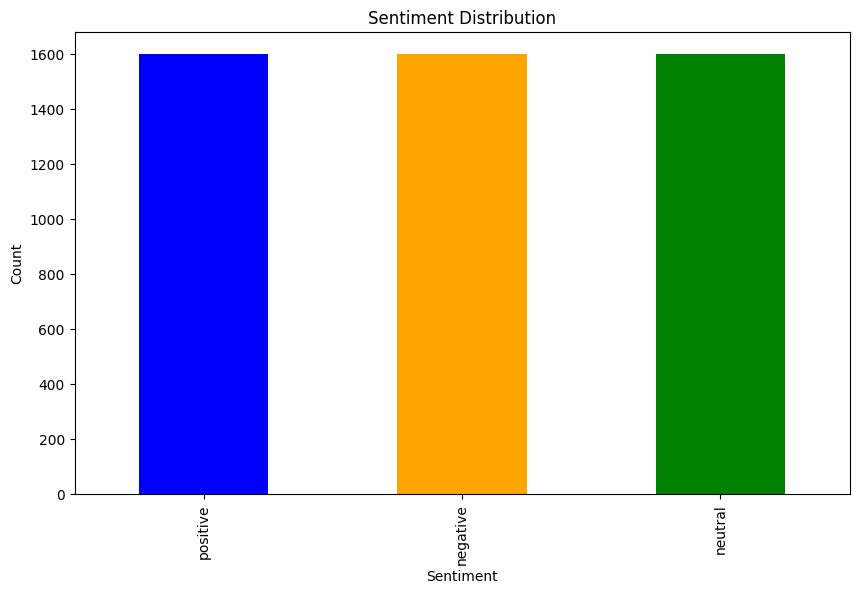

In [25]:
import matplotlib.pyplot as plt

# Count the occurrences of each sentiment
sentiment_counts = df['Sentiment'].value_counts()

# Plot the sentiment distribution
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


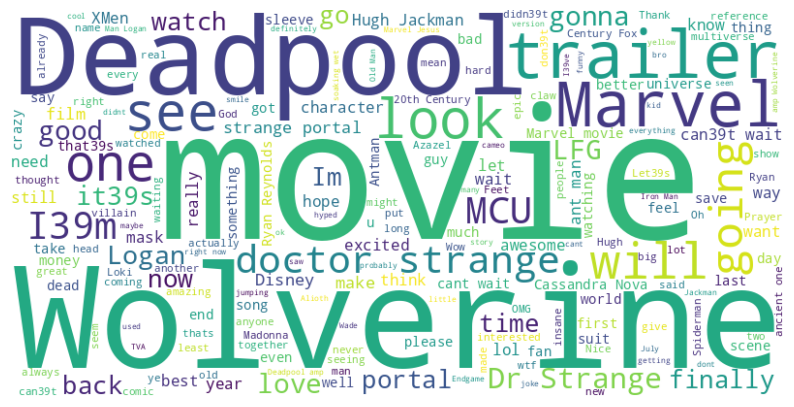

In [26]:
from wordcloud import WordCloud

# Combine all comments into a single string
comments_text = ' '.join(df['Cleaned_Comment'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments_text)

# Plot the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Preprocessing

In [29]:
!pip install spacy
!python -m spacy download en_core_web_lg
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [30]:
import spacy

nlp = spacy.load("en_core_web_lg")

In [31]:
def preprocess(text):
    doc = nlp(text)

    filtered_tokens = []

    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)

    return " ".join(filtered_tokens)

In [32]:
df['clean_text'] = df['Cleaned_Comment'].apply(preprocess)

In [33]:
df.head()

,comment,Cleaned_Comment,Sentiment,clean_text
3218,Who Is Happy For The First R-Rated MCU film,Who Is Happy For The First RRated MCU film,positive,happy RRated MCU film
6914,THIS LOOKS AMAZING ❤❤❤❤,THIS LOOKS AMAZING,positive,look amazing
9770,wow,wow,positive,wow
10141,"Man sad, man watch logan and deadpool, man hap...",Man sad man watch logan and deadpool man happy,positive,man sad man watch logan deadpool man happy
11418,This is an example of a Trilogy where each mov...,This is an example of a Trilogy where each mov...,positive,example trilogy movie get well well thank cast...


# Training the model

In [35]:
df['vector'] = df['clean_text'].apply(lambda x: nlp(x).vector)

In [36]:
df.head()

,comment,Cleaned_Comment,Sentiment,clean_text,vector
3218,Who Is Happy For The First R-Rated MCU film,Who Is Happy For The First RRated MCU film,positive,happy RRated MCU film,"[-1.59915, 1.2234626, -1.501225, -4.6197004, -..."
6914,THIS LOOKS AMAZING ❤❤❤❤,THIS LOOKS AMAZING,positive,look amazing,"[1.5149701, 1.3118501, -2.78935, -2.9635499, 1..."
9770,wow,wow,positive,wow,"[3.0346, -1.1054, -0.23757, 0.19513, -0.98064,..."
10141,"Man sad, man watch logan and deadpool, man hap...",Man sad man watch logan and deadpool man happy,positive,man sad man watch logan deadpool man happy,"[0.32047254, 1.1363688, -1.5732294, -1.9224813..."
11418,This is an example of a Trilogy where each mov...,This is an example of a Trilogy where each mov...,positive,example trilogy movie get well well thank cast...,"[-1.1683518, 0.25151664, -1.618771, -1.834563,..."


In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.vector.values,
    df.Sentiment,
    test_size=0.2,
    random_state=2024
)

In [38]:
X_train.shape

(3840,)

In [39]:
# since the x_train we got was a single numpy array, so we need to convert it to 2D

import numpy as np

X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [40]:
X_train_2d.shape

(3840, 300)

In [41]:
# scaling the data in the range of [0,1] to avoid negative values

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)

In [42]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(scaled_train_embed, y_train)

MultinomialNB()

# Evaluating the model

In [43]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(scaled_test_embed)

conf_matrix = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.60      0.35      0.44       335
     neutral       0.52      0.63      0.57       321
    positive       0.50      0.61      0.55       304

    accuracy                           0.53       960
   macro avg       0.54      0.53      0.52       960
weighted avg       0.54      0.53      0.52       960



# Ploting the results

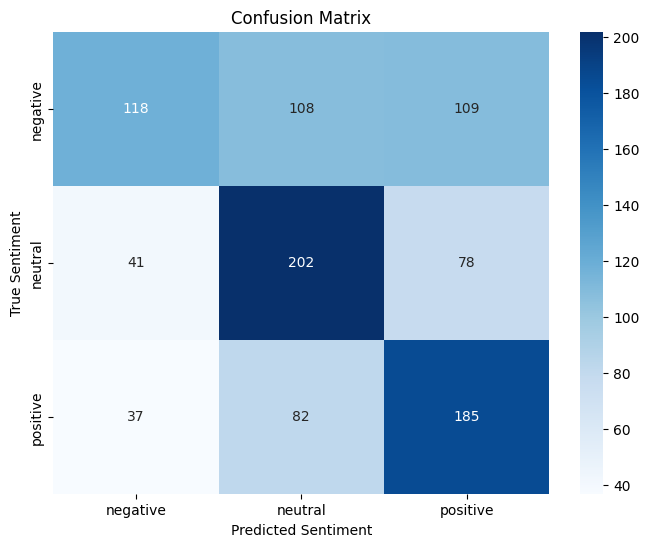

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.title('Confusion Matrix')
plt.show()

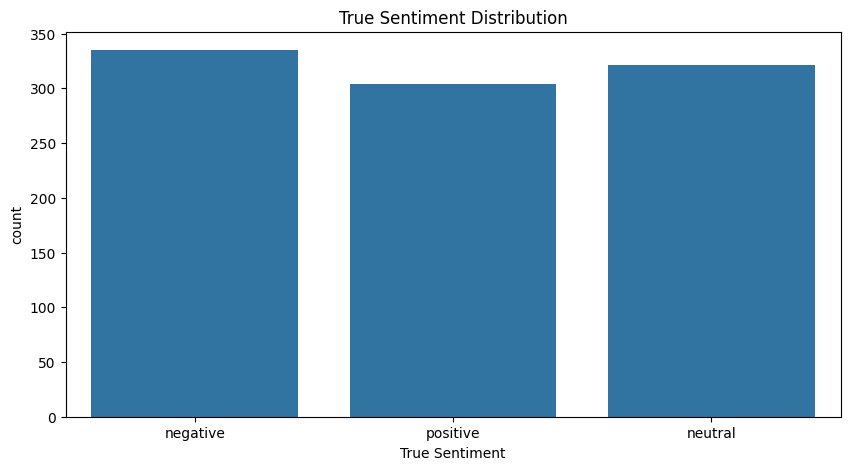

In [48]:
# Create a DataFrame for true and predicted sentiments
results_df = pd.DataFrame({'True Sentiment': y_test, 'Predicted Sentiment': y_pred})

# Distribution of true sentiments
plt.figure(figsize=(10, 5))
sns.countplot(data=results_df, x='True Sentiment')
plt.title('True Sentiment Distribution')
plt.show()

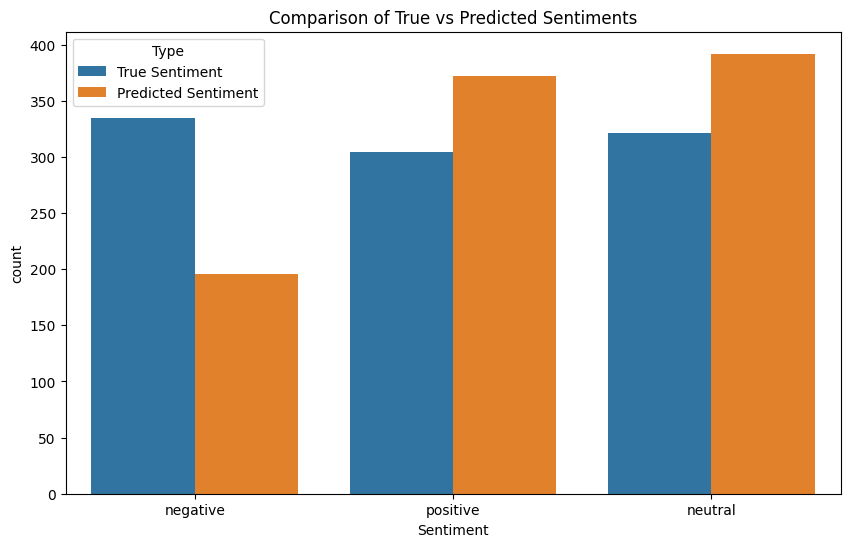

In [49]:
# Comparison of true and predicted sentiments
comparison_df = results_df.melt(var_name='Type', value_name='Sentiment')

plt.figure(figsize=(10, 6))
sns.countplot(data=comparison_df, x='Sentiment', hue='Type')
plt.title('Comparison of True vs Predicted Sentiments')
plt.show()

# Saving the model

In [51]:
from joblib import dump

dump(clf, '/content/drive/MyDrive/Colab Notebooks/model.joblib')

['/content/drive/MyDrive/Colab Notebooks/model.joblib']